In [1]:
from google.colab import drive
drive.mount(r'/content/drive')

# Importo librerías que vamos a usar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Accedo a la PWT. En este caso, yo la tengo cargada en mi drive :)
file_path_1 = '/content/drive/MyDrive/Colab Notebooks/economic-growth/pwt1001.xlsx' # Modificar el path según sea necesario
pwt = pd.read_excel(file_path_1, sheet_name="Data") # Poner el nombre de la hoja tal cual. Con esto armamos un dataframe

# Agrego como columnas las variables a calcular
pwt['S']=pwt['rdana']-pwt['rconna'] # Ahorro
pwt['Y per cápita']=pwt['rgdpna']/pwt['pop'] # PBI per cápita
pwt['Tasa de ahorro']=pwt['S']/pwt['rgdpna'] # Tasa de ahorro
pwt['Share de capital'] = 1 - pwt['labsh'] # Share de Capital
pwt['K per cápita']= pwt['rnna']/pwt['pop'] # Capital per cápita

greece = pwt[pwt["country"] == "Greece"].copy()

Mounted at /content/drive


In [2]:
# Tasa de crecimiento garantizada
# Gw = s / (K/Y)
greece['v'] = greece['rnna']/greece['rgdpna']
greece['Gw']=greece['Tasa de ahorro']/greece['v']
# G = (V_hoy -V_ayer) / V_ayer = s/C_p --> es la tasa de crecimiento per cápita
greece['G'] = greece['rgdpna'].pct_change()
#greece['G'] = (greece['Tasa de ahorro']/((greece['rnna'].pct_change()/greece['rgdpna'].pct_change())))

In [3]:
# Quiero obtener una estimación de estos países, por lo que voy a buscar la media
greece_Gw = np.mean(greece['Gw'])*100
greece_G = np.mean(greece['G'])*100

print('Tasa de crecimiento garantizada:',greece_Gw,'%')
print('Tasa de crecimiento efectiva:',greece_G,'%')

Tasa de crecimiento garantizada: 4.3908229223683986 %
Tasa de crecimiento efectiva: 3.0961366424527568 %


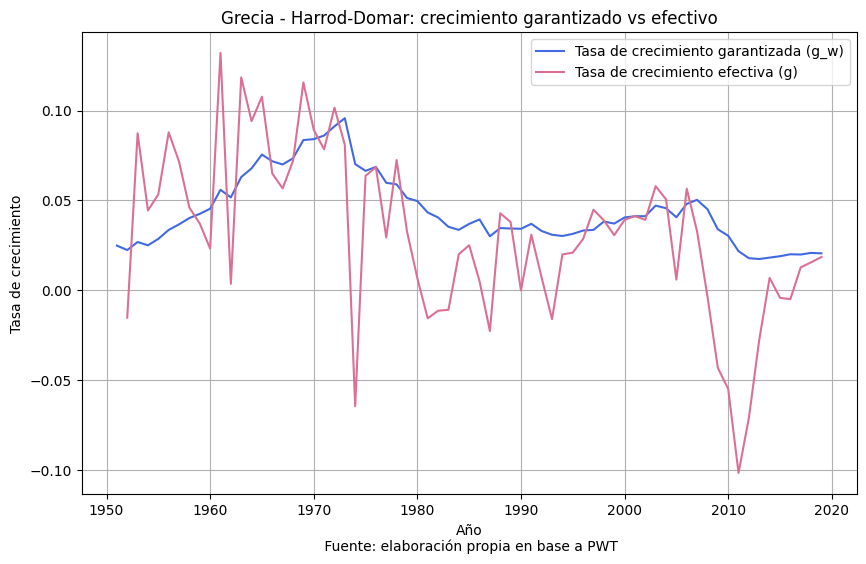

In [4]:
import matplotlib.pyplot as plt

# --- Graficar ---
plt.figure(figsize=(10,6))
plt.plot(greece['year'], greece['Gw'], label="Tasa de crecimiento garantizada (g_w)", color="royalblue")
plt.plot(greece['year'], greece['G'],  label="Tasa de crecimiento efectiva (g)", color="palevioletred")

plt.title("Grecia - Harrod-Domar: crecimiento garantizado vs efectivo")
plt.xlabel("Año\n Fuente: elaboración propia en base a PWT")
plt.ylabel("Tasa de crecimiento")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# Aplicación del trabajo de Vandenberg y Rosete (2019)
# Utilizaremos como tita la base de datos de 'Total natural resources rents (% of GDP)' del World Bank

# Instalamos la librería de World Bank API
!pip install wbdata
import wbdata
import pandas as pd
import datetime

# Definimos el periodo de tiempo que queremos. Los datos van a ser desde 1970 :')
start = datetime.datetime(1950, 1, 1)
end   = datetime.datetime(2019, 12, 31)

resource_rents = {"NY.GDP.TOTL.RT.ZS": "resource_rents_percent_GDP"}

# Fetch data
data_raw = wbdata.get_dataframe(resource_rents, country="GRC", date=(start, end))
data = data_raw.reset_index().rename(columns={"date": "year"})

#}

#data_raw = wbdata.get_dataframe(resource_rents, country="GRC", date=(start, end))
#print(data_raw.head(52))
#data = data_raw.reset_index().rename(columns={"date":"year"})
data["year"] = data["year"].astype(int)

#print("Datos descargados de WDI (primeras filas):")
#print(data.head(10))
if "resource_rents_percent_GDP" in greece.columns:
    greece = greece.drop(columns=["resource_rents_percent_GDP"])
greece = pd.merge(greece, data, on="year", how="left")

#greece = pd.merge(greece, data, on="year", how="left") # Lo sumamos al df de Greece
#print(greece)
greece['tita'] = greece['resource_rents_percent_GDP']
#greece['tita'] = greece['resource_rents'] #/100 # Convertimos tita en un estimador!
print(greece['tita'])

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
        ...   
65    0.071351
66    0.090598
67    0.107741
68    0.107924
69    0.070476
Name: tita, Length: 70, dtype: float64


In [14]:
# Estimamos el nuevo crecimiento

# Reducción multiplicativa (s' = 0.96 * s)
greece['s_adj_mult'] = greece['Tasa de ahorro'] * (1 - greece['tita'])
greece['gw_adj_mult'] = greece['s_adj_mult'] / greece['v']

theta_vandelberg = 0.04
greece['s_vandelberg'] = greece['Tasa de ahorro'] * (1- theta_vandelberg)
greece['gw_vandelberg'] = greece['s_vandelberg'] / greece['v']

# Lo comparamos con Gw del modelo original
summary = pd.DataFrame({
    'year': greece['year'],
    's': greece['Tasa de ahorro'],
    'v': greece['v'],
    'g_efectiva': greece['G'],
    'gw_original': greece['Gw'],
    'gw_adj_mult': greece['gw_adj_mult'],
    's_vandelberg': greece['s_vandelberg']
})

print("Promedios históricos (Grecia):")
print(summary[['gw_original','gw_adj_mult']].mean()*100)


Promedios históricos (Grecia):
gw_original    4.390823
gw_adj_mult    3.206224
dtype: float64


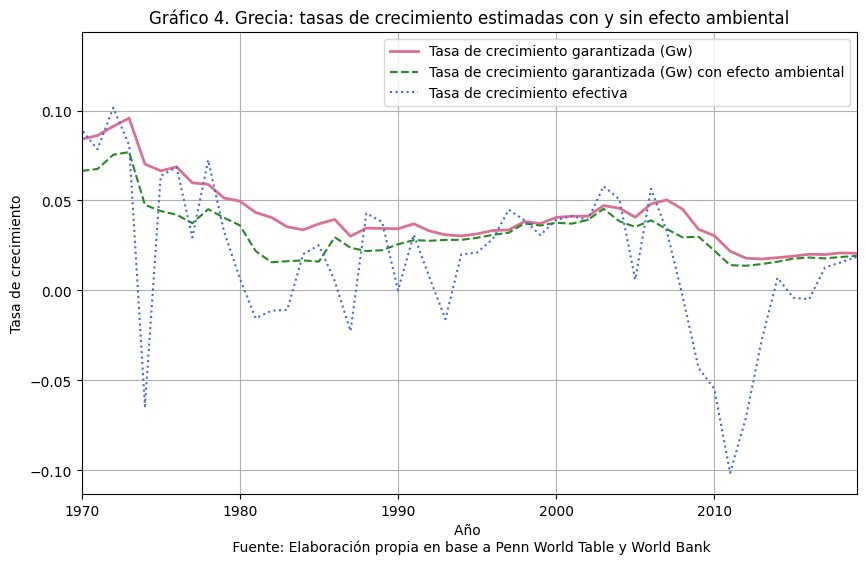

Reducción promedio (mult): 26.98%


In [26]:
# Observamos graficamente la diferencia

colores = {
    'gw_original': 'palevioletred',
    'gw_adj_mult': 'forestgreen',
    'g_efectiva': 'royalblue',
    's_vandelberg': 'orange'
}
# Graficar las tres series de gw a lo largo del tiempo
plt.figure(figsize=(10,6))

plt.xlim(1970, summary['year'].max())

plt.plot(summary['year'], summary['gw_original'], label='Tasa de crecimiento garantizada (Gw)', linewidth=2, color=colores['gw_original'])  # Harrod-Domar
plt.plot(summary['year'], summary['gw_adj_mult'], label='Tasa de crecimiento garantizada (Gw) con efecto ambiental', linestyle='--', color=colores['gw_adj_mult'])  # Vandenberg y Rosete
plt.plot(summary['year'], summary['g_efectiva'], label='Tasa de crecimiento efectiva', linestyle=':', color=colores['g_efectiva'])  # Real
#plt.plot(summary['year'], summary['s_vandelberg'], label='Gw con efecto ambiental (4%)', linestyle=':', color=colores['s_vandelberg']) # Real
plt.xlabel('Año \n Fuente: Elaboración propia en base a Penn World Table y World Bank')
plt.ylabel('Tasa de crecimiento')
plt.title('Gráfico 4. Grecia: tasas de crecimiento estimadas con y sin efecto ambiental')
plt.legend()
plt.grid(True)
plt.show()

# Calcular reducción porcentual promedio
orig_mean = summary['gw_original'].mean()
mult_mean = summary['gw_adj_mult'].mean()

print(f"Reducción promedio (mult): {(orig_mean - mult_mean)/orig_mean*100:.2f}%")
#print(f"Reducción promedio (add):  {(orig_mean - add_mean)/orig_mean*100:.2f}%")